In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-sales/sample_submission.csv
/kaggle/input/amazon-sales/train.csv
/kaggle/input/amazon-sales/test.csv


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler



In [4]:
# Load the train and test data
train_data = pd.read_csv('/kaggle/input/amazon-sales/train.csv')
test_data = pd.read_csv('/kaggle/input/amazon-sales/test.csv')

# Convert date column to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

print(train_data.info())
print(train_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          101490 non-null  object        
 1   date        101490 non-null  datetime64[ns]
 2   Item Id     101488 non-null  object        
 3   Item Name   99658 non-null   object        
 4   ad_spend    77303 non-null   float64       
 5   anarix_id   101490 non-null  object        
 6   units       83592 non-null   float64       
 7   unit_price  101490 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 6.2+ MB
None
                                date      ad_spend         units  \
count                         101490  77303.000000  83592.000000   
mean   2023-07-09 19:17:37.120898560    110.771470     10.284381   
min              2022-04-12 00:00:00      0.000000   -173.000000   
25%              2023-02-26 00:00:00      0.000000  

In [17]:
# Check for missing values
print("\nMissing Values:")
print(train_data.isnull().sum())





Missing Values:
ID                  0
date                0
Item Id             2
Item Name        1832
ad_spend            0
anarix_id           0
units               0
unit_price          0
total_revenue       0
dtype: int64


In [19]:
# Fill missing 'ad_spend' with 0, 'units' with mode, 'unit_price' with mean
train_data['ad_spend'].fillna(0, inplace=True)
train_data['units'].fillna(train_data['units'].mode()[0], inplace=True)
train_data['unit_price'].fillna(train_data['unit_price'].mean(), inplace=True)

# Convert 'date' to datetime
train_data['date'] = pd.to_datetime(train_data['date'], format='%d-%m-%Y')

# Summary statistics
print("\nSummary Statistics:")
print(train_data.describe())

# Detect outliers using IQR method for 'ad_spend', 'units', and 'unit_price'
def detect_outliers(column):
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = train_data[(train_data[column] < Q1 - 1.5 * IQR) | (train_data[column] > Q3 + 1.5 * IQR)]
    return outliers

ad_spend_outliers = detect_outliers('ad_spend')
units_outliers = detect_outliers('units')
unit_price_outliers = detect_outliers('unit_price')

print(f"\nNumber of ad_spend outliers: {len(ad_spend_outliers)}")
print(f"Number of units outliers: {len(units_outliers)}")
print(f"Number of unit_price outliers: {len(unit_price_outliers)}")



Summary Statistics:
                                date       ad_spend          units  \
count                         101490  101490.000000  101490.000000   
mean   2023-07-09 19:17:37.120898560      66.998912       6.333649   
min              2022-04-12 00:00:00       0.000000       0.000000   
25%              2023-02-26 00:00:00       0.000000       0.000000   
50%              2023-07-16 00:00:00       0.720000       0.000000   
75%              2023-12-13 00:00:00      21.640000       3.000000   
max              2024-05-31 00:00:00    1529.219800     148.000000   
std                              NaN     216.544333      20.175675   

          unit_price  total_revenue  
count  101490.000000  101490.000000  
mean       94.127173    2215.811131  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max      1890.000000  279720.000000  
std       291.938640   12458.834477  

Numbe

/tmp/ipykernel_34/1404082552.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['ad_spend'].fillna(0, inplace=True)
/tmp/ipykernel_34/1404082552.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


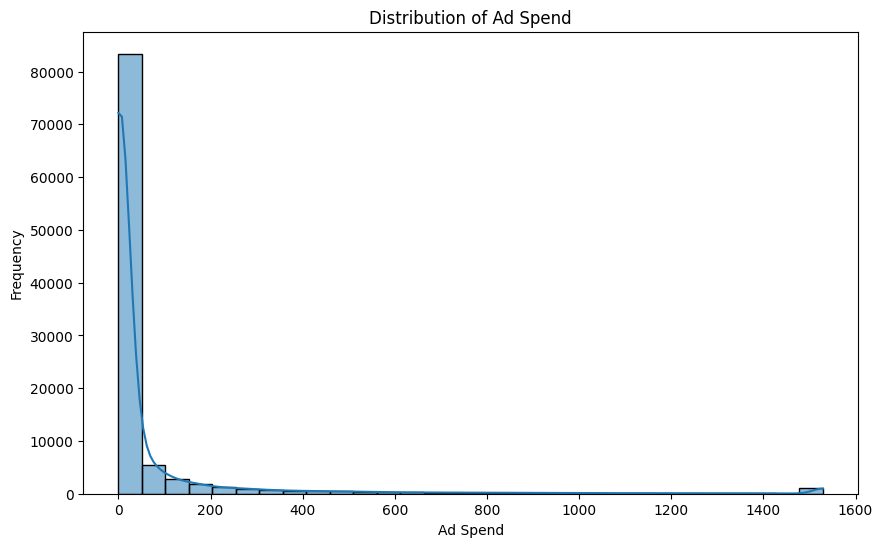

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


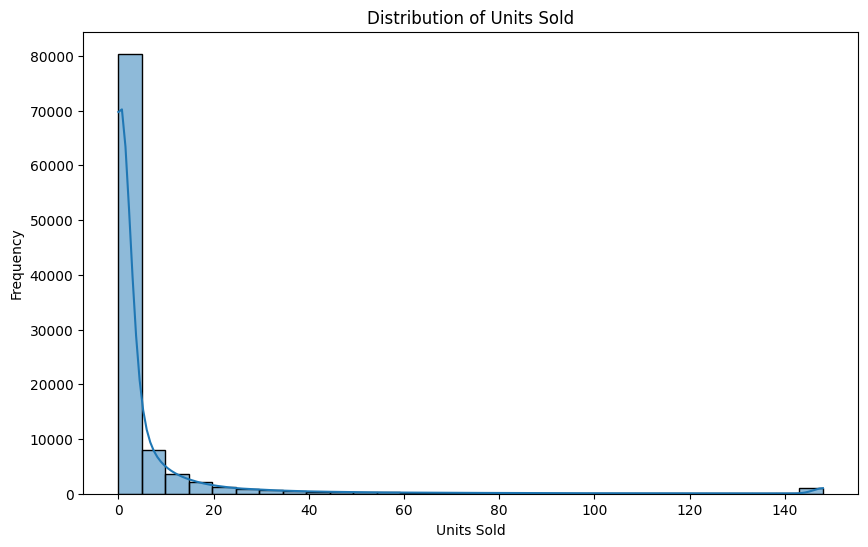

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


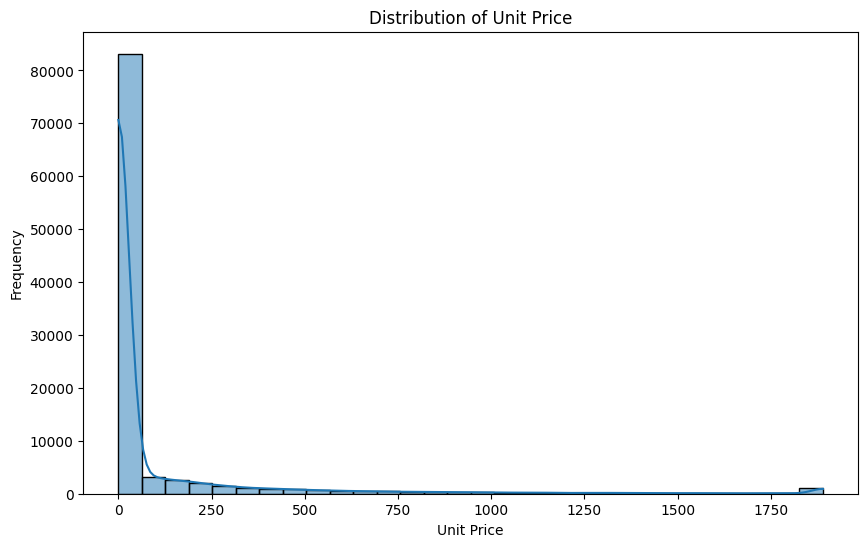

In [20]:
# Feature engineering: Total revenue
train_data['total_revenue'] = train_data['units'] * train_data['unit_price']

# EDA: Distribution of 'ad_spend'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['ad_spend'], bins=30, kde=True)
plt.title('Distribution of Ad Spend')
plt.xlabel('Ad Spend')
plt.ylabel('Frequency')
plt.show()

# EDA: Distribution of 'units'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['units'], bins=30, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

# EDA: Distribution of 'unit_price'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['unit_price'], bins=30, kde=True)
plt.title('Distribution of Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_columns = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr = numeric_columns.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



The variables units and ad_spend have the strongest correlation (0.60), suggesting that marketing efforts have a significant impact on sales volume.
total_revenue is moderately influenced by both units and unit_price, indicating that revenue is a function of both the quantity sold and the pricing strategy.
Understanding these correlations helps identify which factors are most closely associated with sales performance and revenue, allowing for more informed decision-making in marketing and pricing strategies.



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


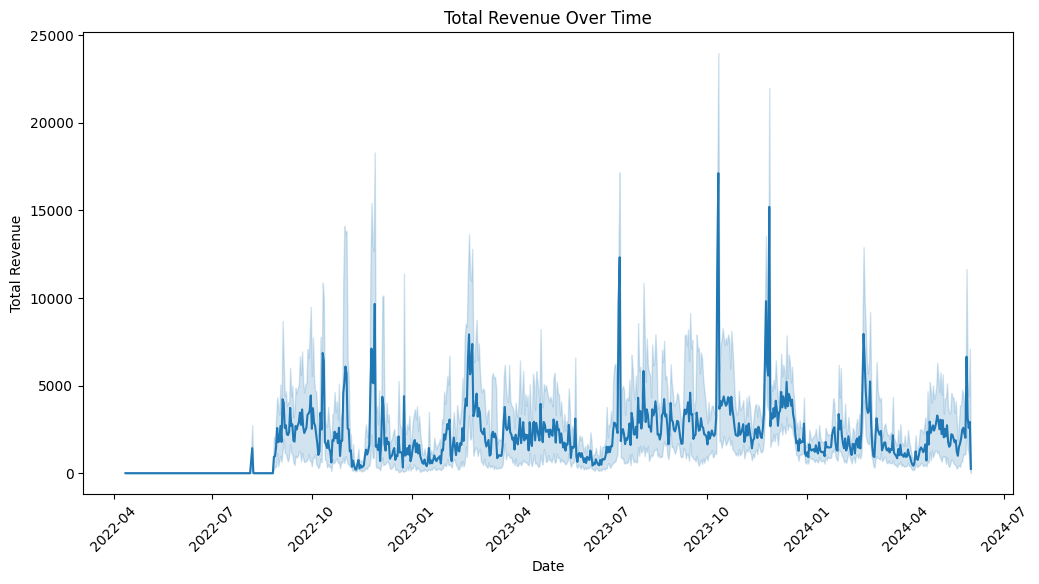

In [28]:
# Time Series Analysis: Total Revenue Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x='date', y='total_revenue')
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

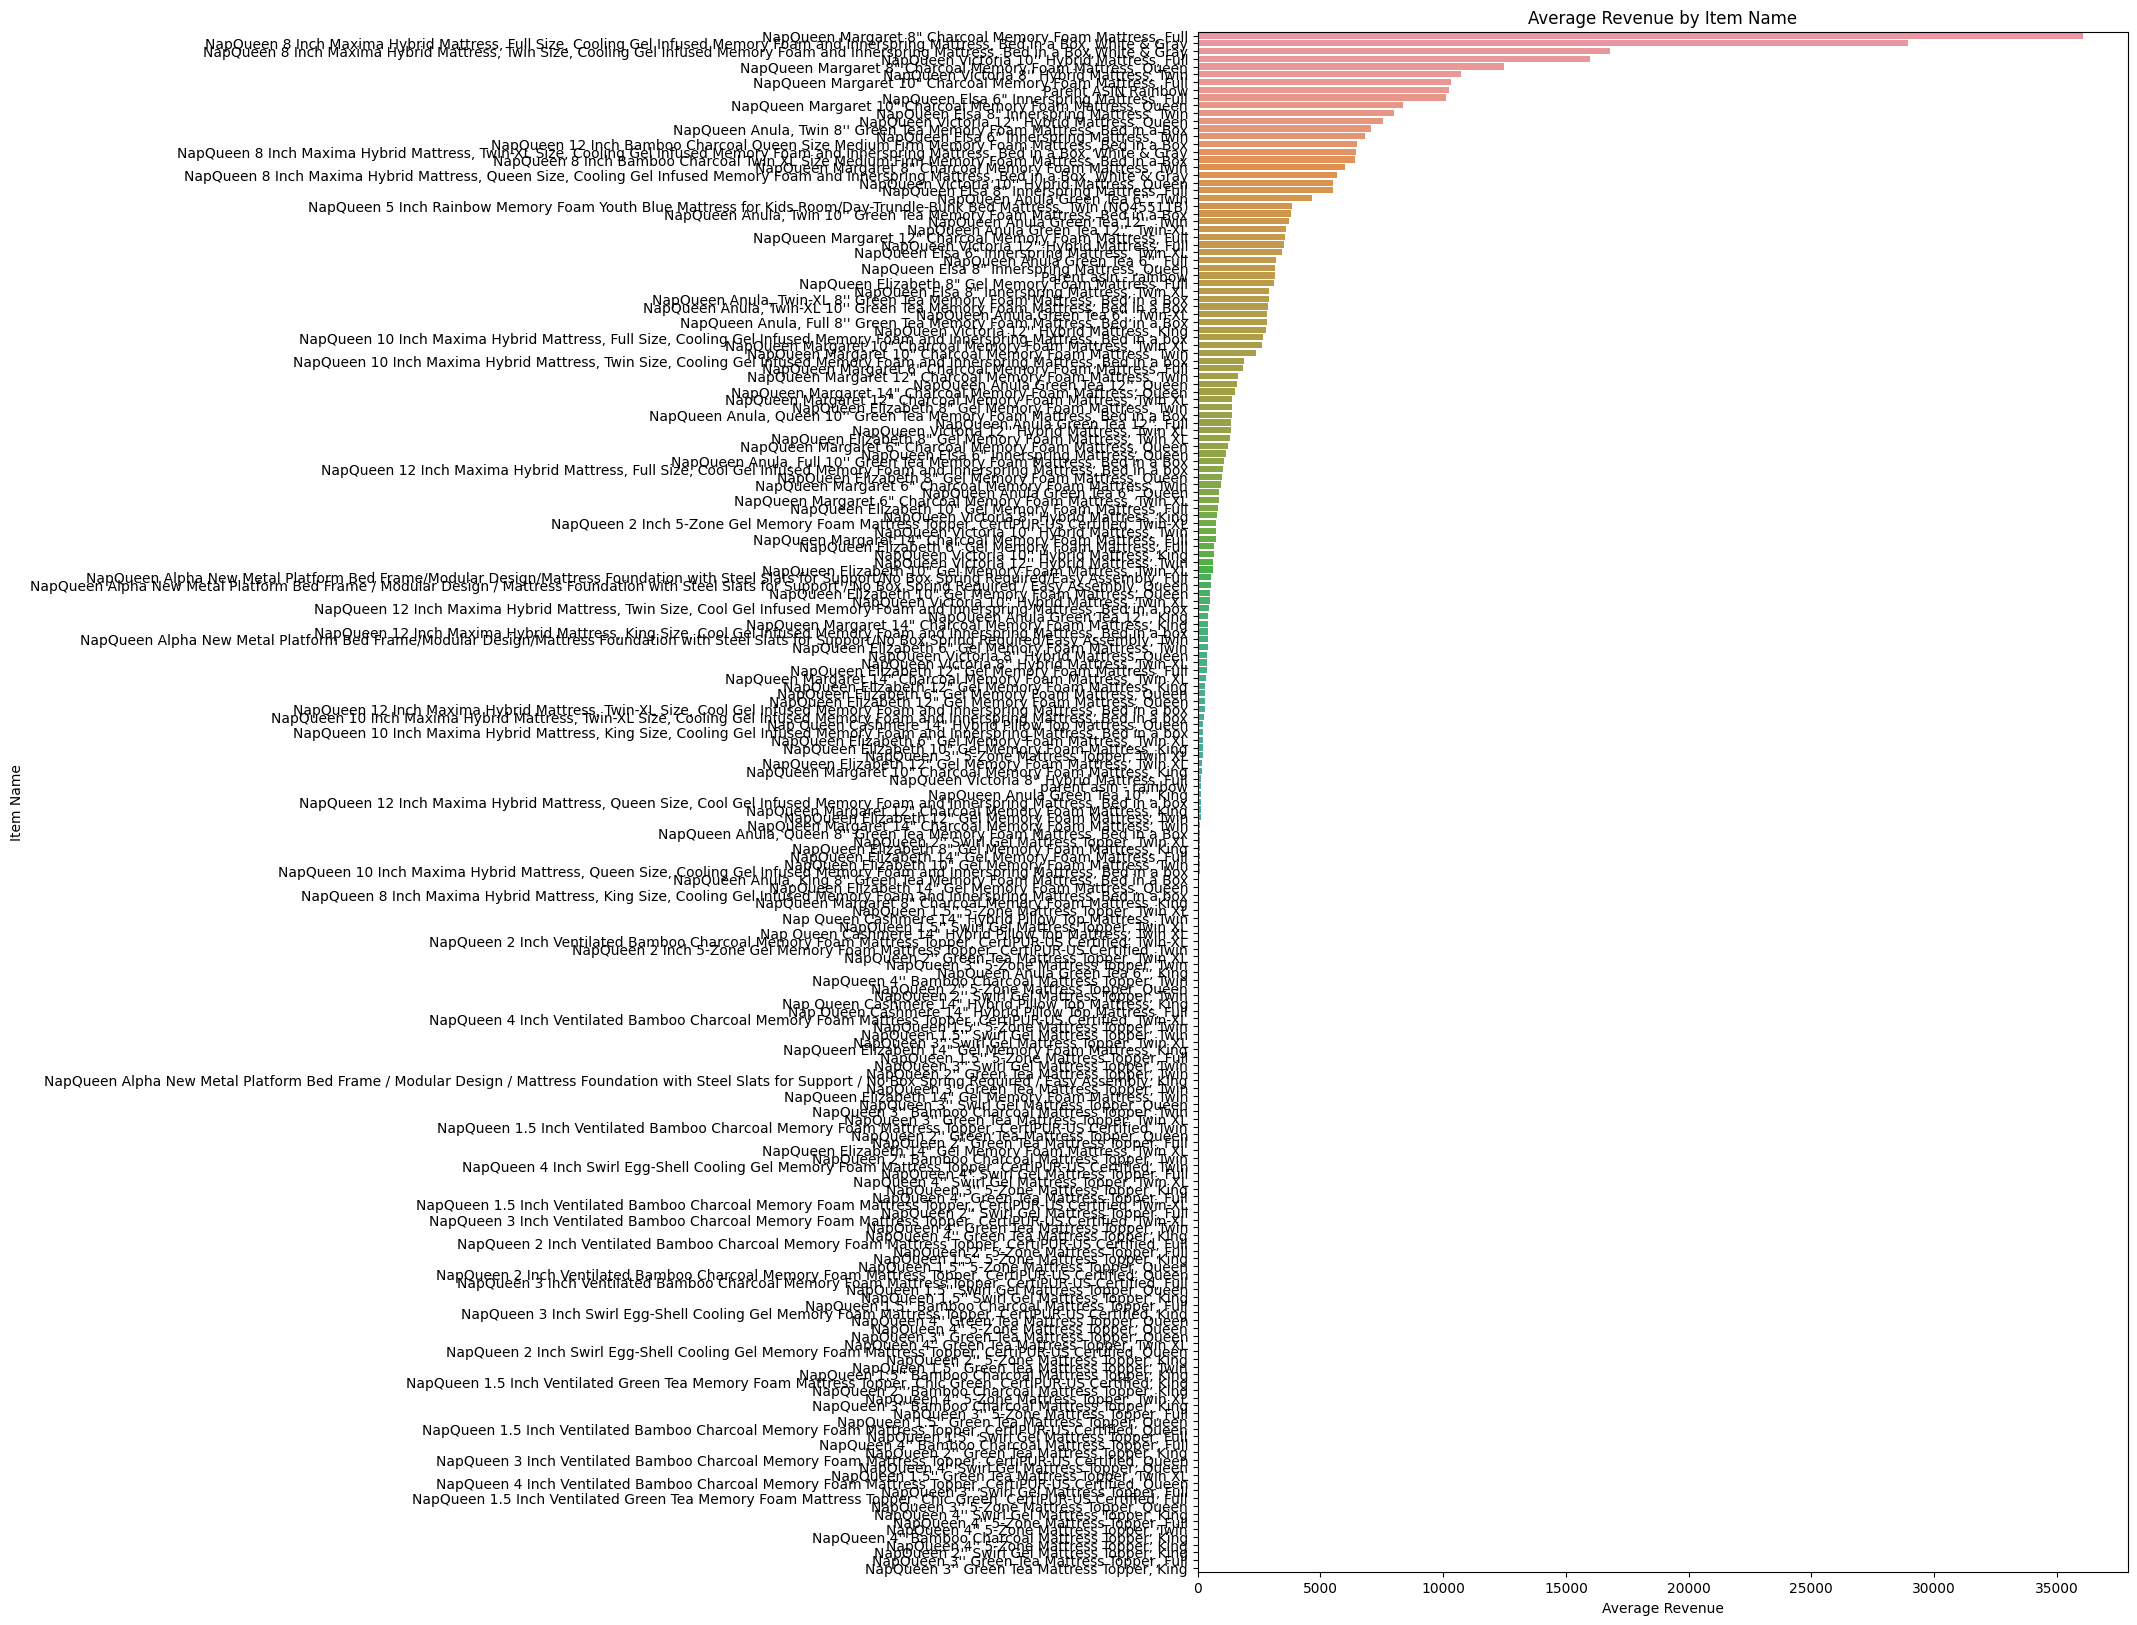

In [27]:
# Category Analysis: Average Revenue by Item Name
avg_revenue_by_item = train_data.groupby('Item Name')['total_revenue'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 20))
sns.barplot(x=avg_revenue_by_item, y=avg_revenue_by_item.index)
plt.title('Average Revenue by Item Name')
plt.xlabel('Average Revenue')
plt.ylabel('Item Name')
plt.show()

In [34]:
# Define categorical and numerical features
cat_features = ['Item Id', 'anarix_id']
num_features = ['dayofweek', 'unit_price', 'price_to_adspend', 'day', 'year', 'ad_spend', 'month']

# One-hot encode categorical features
train_encoded = pd.get_dummies(train_data, columns=cat_features, prefix=cat_features)
test_encoded = pd.get_dummies(test_data, columns=cat_features, prefix=cat_features)

# Ensure train and test have the same columns
common_columns = train_encoded.columns.intersection(test_encoded.columns)
train_encoded = train_encoded[common_columns]
test_encoded = test_encoded[common_columns]

# Prepare features and target
features = num_features + [col for col in train_encoded.columns if col.startswith(tuple(cat_features))]
X = train_encoded[features]
y = train_data['units']

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Lists to store cross-validation results
cv_scores = []

# Train the model with cross-validation
for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    
    # Predict on validation set
    val_pred = model.predict(X_val)
    
    # Calculate MSE for this fold
    mse = mean_squared_error(y_val, val_pred)
    cv_scores.append(mse)
    
    print(f"Fold {fold} - MSE: {mse}")

# Print average cross-validation score
print(f"Average MSE across all folds: {np.mean(cv_scores)}")

# Retrain on full training data
model.fit(X, y)

# Make predictions on test set
X_test = test_encoded[features]
predictions = model.predict(X_test)

# Prepare submission
submission = pd.DataFrame({
    'date': test_df['date'],
    'Item Id': test_df['Item Id'],
    'units': predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

KeyError: "['dayofweek', 'price_to_adspend', 'day', 'year', 'month'] not in index"

In [ ]:
# Evaluate the model
mse = mean_squared_error(test_data[target], predictions)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], test_data[target], label='Actual Sales')
plt.plot(test_data['date'], predictions, label='Predicted Sales', linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

# Prepare submission file
submission = pd.DataFrame({
    'Item Id': test_data['Item Id'],
    'Date': test_data['date'],
    'Predicted Units': predictions
})

# Save the results to a CSV file
submission.to_csv('predicted_sales.csv', index=False)